In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

In [20]:
import tensorflow_hub as hub

#특징 추출기 불러오기( inception_resnet_v2 )
inception_url = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, 
                   output_shape=(1536,), 
                   trainable=False)
])
feature_model.build([None, 224,224 , 3])
feature_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1536)              54336736  
Total params: 54,336,736
Trainable params: 0
Non-trainable params: 54,336,736
_________________________________________________________________


In [21]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224
batch_size = 1

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
# seed 값이 같으므로 train subset과 validation subset이 중복될 일은 없다.
# batch_size = 32, shuffle=True이므로 랜덤하게 32개의 이미지를 디렉토리에서 골라서 보강하여 반환한다.
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/COVID-19 Radiography Database/data', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/COVID-19 Radiography Database/data',
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))


Found 2785 images belonging to 3 classes.
Found 696 images belonging to 3 classes.


In [22]:
# 학습데이터의 3배정도 이미지가 보강되도록 한다.
import numpy as np

train_features = [] # 빈 리스트 생성 
train_Y = [] # 빈 리스트 생성 

for idx in range(train_generator.n): # 2785 
  if idx % 100 == 0: #만약 0 포함 100의 배수일때 
    print(idx) #(진행상황 표기)
  x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.  
  print(idx)
  train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
#   print(x.shape, y.shape) --> (32, 299, 299, 3), (32, 120)
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
#   print(feature.shape) --> (32,2048)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape) 

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


In [23]:
valid_features = [] # 빈 리스트 생성 
valid_Y = [] # 빈 리스트 생성 


for idx in range(valid_generator.n): ## valid_generator.n = 696 (검증데이터의 수)
  if idx % 100 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  print(idx)
  valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


In [66]:
# 간단한 Sequential 모델을 정의 --> 나중에 가장 좋은 훈련시의 checkpoint를 가져오기 위해 모델 구조를 함수로 저장
def create_model():
    model = tf.keras.Sequential([
                                tf.keras.layers.Dense(256, activation= 'relu', input_shape = (1536,)),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(256, activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(3,activation='softmax')
    ])
    model.compile(tf.optimizers.RMSprop(0.0001), 
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
    return model
# 모델 객체를 만듬
model = create_model()

# 모델 구조를 출력
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 771       
Total params: 460,035
Trainable params: 460,035
Non-trainable params: 0
_________________________________________________________________


In [67]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = '/content/drive/My Drive/인공지능 학습관련/covid19_detection_model'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)
# es = EarlyStopping(patience=15, verbose=1)
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 100,
                    batch_size = 32,
                    callbacks=cp)

Epoch 1/100
83/88 [===========================>..] - ETA: 0s - loss: 0.8237 - accuracy: 0.6510
Epoch 00001: val_accuracy improved from -inf to 0.86638, saving model to /content/drive/My Drive/인공지능 학습관련/covid19_detection_model
88/88 [==============================] - 0s 5ms/step - loss: 0.8183 - accuracy: 0.6546 - val_loss: 0.3833 - val_accuracy: 0.8664
Epoch 2/100
80/88 [==========================>...] - ETA: 0s - loss: 0.4583 - accuracy: 0.8242
Epoch 00002: val_accuracy did not improve from 0.86638
88/88 [==============================] - 0s 3ms/step - loss: 0.4628 - accuracy: 0.8212 - val_loss: 0.3262 - val_accuracy: 0.8635
Epoch 3/100
83/88 [===========================>..] - ETA: 0s - loss: 0.3675 - accuracy: 0.8502
Epoch 00003: val_accuracy improved from 0.86638 to 0.87787, saving model to /content/drive/My Drive/인공지능 학습관련/covid19_detection_model
88/88 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.8517 - val_loss: 0.2935 -

훈련이 끝난 후의 최종 model loss/ accuracy

In [68]:
# model.save('/content/drive/My Drive/인공지능 학습관련/covid_model_size224.h5')
print(model.evaluate(valid_features, valid_Y))

22/22 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.9612
[0.12080705910921097, 0.9612069129943848]


훈련 중 가장 acc가 높았던 checkpoint의 loss/accuracy

In [69]:
model2 = create_model()
# 가중치 로드
model2.load_weights(checkpoint_path)

# 모델 평가
print(model2.evaluate(valid_features, valid_Y))

22/22 [==============================] - 0s 2ms/step - loss: 0.1078 - accuracy: 0.9655
[0.10778894275426865, 0.9655172228813171]


In [65]:
print(model2.evaluate(valid_features, valid_Y))

22/22 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9583
[0.12810897827148438, 0.9583333134651184]


best model 저장


In [70]:
model2.save('/content/drive/My Drive/인공지능 학습관련/covid_model_size224_best.h5')

Viral Pneumonia Viral Pneumonia
COVID-19 COVID-19
NORMAL NORMAL
Viral Pneumonia Viral Pneumonia
Viral Pneumonia Viral Pneumonia
NORMAL NORMAL
Viral Pneumonia NORMAL
COVID-19 Viral Pneumonia
NORMAL NORMAL
NORMAL NORMAL
Viral Pneumonia NORMAL
COVID-19 COVID-19
Viral Pneumonia NORMAL
Viral Pneumonia Viral Pneumonia
NORMAL NORMAL
NORMAL NORMAL
Viral Pneumonia Viral Pneumonia
Viral Pneumonia Viral Pneumonia
NORMAL NORMAL
Viral Pneumonia Viral Pneumonia
Viral Pneumonia Viral Pneumonia
COVID-19 COVID-19
NORMAL NORMAL
COVID-19 COVID-19
Viral Pneumonia Viral Pneumonia
Viral Pneumonia Viral Pneumonia
NORMAL NORMAL
NORMAL NORMAL
COVID-19 COVID-19
Viral Pneumonia NORMAL


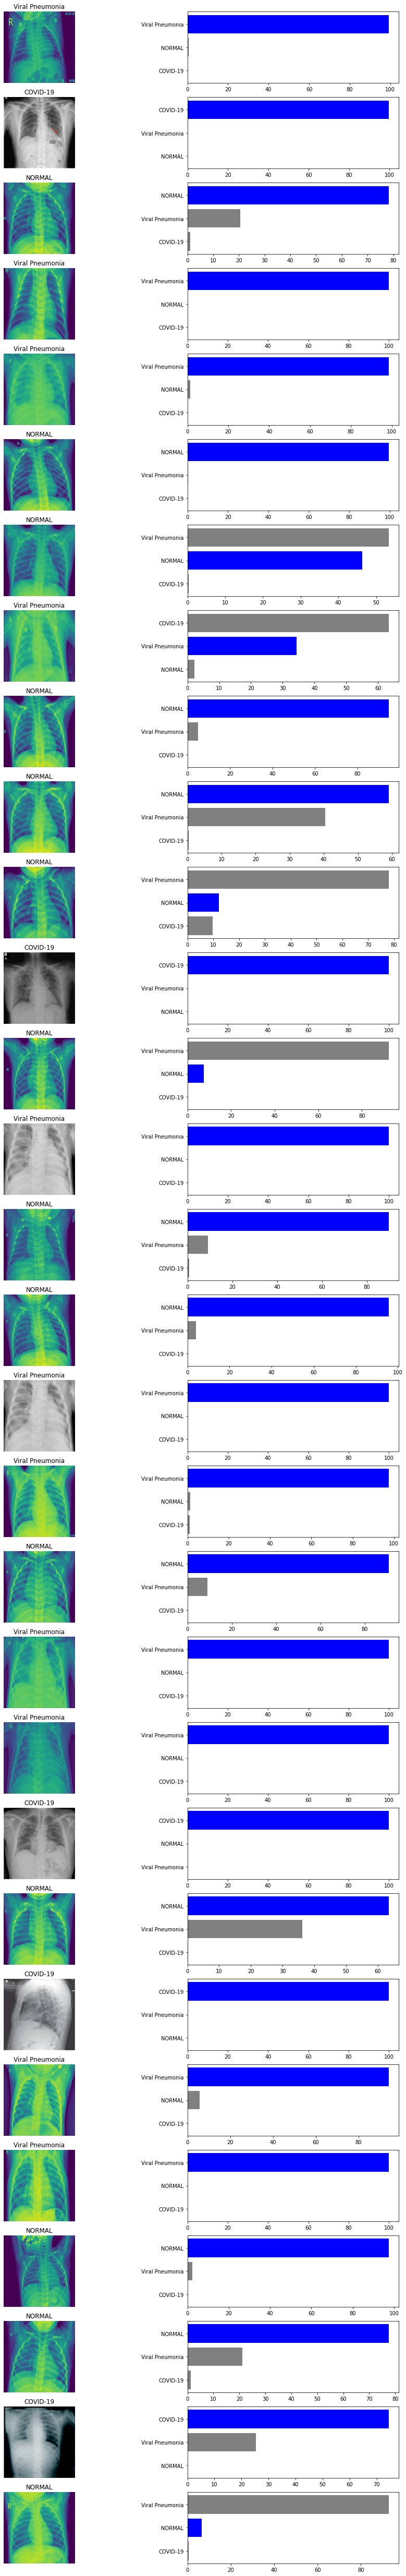

In [71]:
import random
import cv2

predictY = []
realY = []
iter = 30
model = model2

unique_sorted_Y = ['COVID-19','NORMAL','Viral Pneumonia']
plt.figure(figsize=(16,iter*3))



for i in range(iter): 
    image_path = random.choice(valid_generator.filepaths)
    #출력 범위 설정 
    plt.subplot(iter,2,i*2+1)

    #검증데이터 출력 
    plt.imshow(plt.imread(image_path))

    # split('/')를 통해 나눠진 부분 중 3번째 획득
    real_y = image_path.split('/')[-2]
    # real_y → bluetick 출력 

    #타이틀 출력 
    plt.title(real_y)
    plt.axis('off')
    #unique_sorted_Y 에 저장된 값을 바탕으로 real_y의 위치 값 할당 
    idx = unique_sorted_Y.index(real_y)
    # idx → ex) 81, ...  

    


    #예측값 표기
    plt.subplot(iter,2,i * 2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299,299))
    img = img / 255.0
    #차원 추가 (axis=0이 되면 1이 추가됨.(299,299,3)→(1,299,299,3))
    img = np.expand_dims(img, axis=0)

    #img를 Inception V3의 특징 추출기 feature_model을 활용하여 특징 벡터를 생성. 
    feature_vector = feature_model.predict(img)

    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]

    #가장 높은 확률의 예측값을 5개 선출 
    #[::-1] Extended Slices 기법으로 내림차순으로 변경, [:5] 그 중 top 5개
    top_3_predict = prediction.argsort()[::-1][:3]
    #labels에 저장 
    labels = [unique_sorted_Y[index] for index in top_3_predict]
    color = ['gray'] * 3
    #예측 수행한 Top 5 값에 대하여 'blue' 으로 변경
    if idx in top_3_predict:
        color[top_3_predict.tolist().index(idx)] = 'blue'
    color = color[::-1]
    #가로 막대 그리기 
    plt.barh(range(3), prediction[top_3_predict][::-1] * 100, color = color)
    plt.yticks(range(3), labels[::-1])

    # print(labels[0], realY[0])
    predictY.append(labels[0])
    realY.append(real_y)
    print(labels[0],real_y)

In [72]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(predictY, realY)
print(cm)

[[ 5  0  1]
 [ 0 10  0]
 [ 0  4 10]]


In [73]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 5  0  1]
 [ 0 10  0]
 [ 0  4 10]]


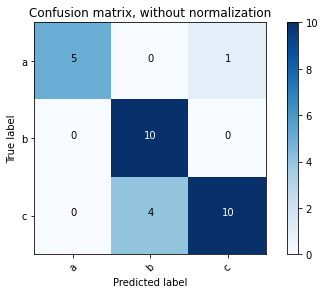

In [74]:
plt.figure()
plot_confusion_matrix(cm, classes=['a', 'b', 'c'], title='Confusion matrix, without normalization')